In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import os
from epi.example_eps import load_W

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
D = 4
lb = -10.*np.ones((D,))
ub = 10.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
purple = '#4C0099'

def plot_T_x(T_x, T_x_sim, bins=30, xmin=None, xmax=None, xlabel=None, ylim=None, fontsize=14):
    if xmin is not None and xmax is not None:
        _range = (xmin, xmax)
    else:
        _range = None
    plt.figure()
    if T_x is None:
        plt.hist(T_x_sim, bins=bins, range=_range, color=purple, alpha=0.5)
    else:
        n, bins, patches = plt.hist(T_x, bins=bins, color='k', range=_range, alpha=0.5)
        plt.hist(T_x_sim, bins=bins, color=purple, alpha=0.5)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('count', fontsize=fontsize)
    return None

In [4]:
import tensorflow as tf

def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

V_INIT = tf.constant(-65.*np.ones((1,4,1)), dtype=np.float32)

k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 5
T = 100

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

def SSSN_sim(h):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]

    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)

    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))

        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise

        return tf.concat((dv, deps), axis=2)

    v_ss = euler_sim_stoch(f, y_init, dt, T)
    return v_ss

SSSN_drdh_E


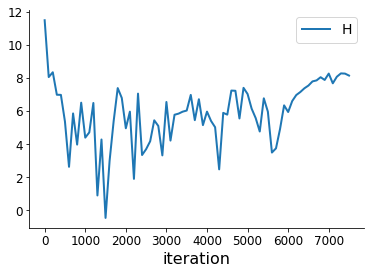

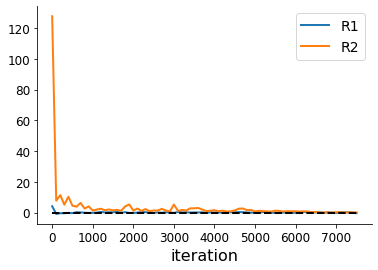

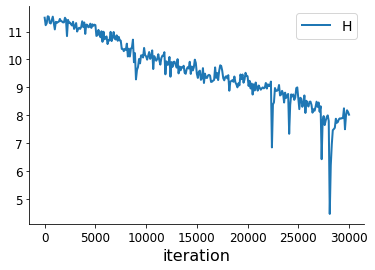

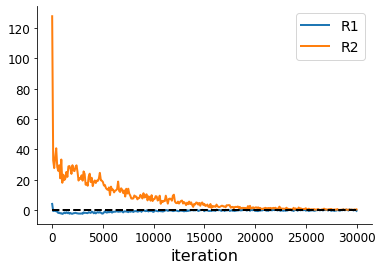

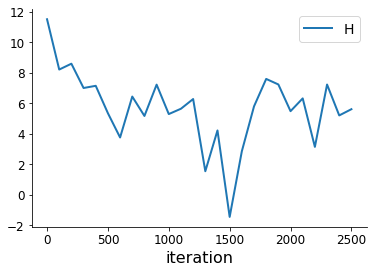

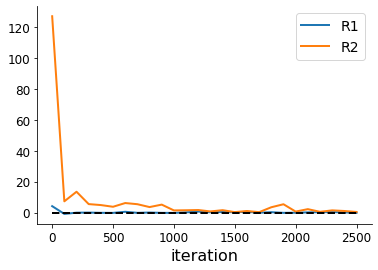

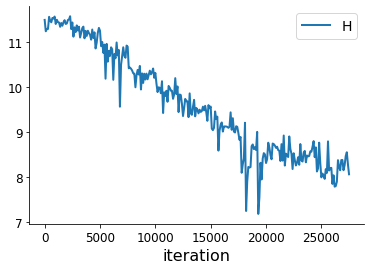

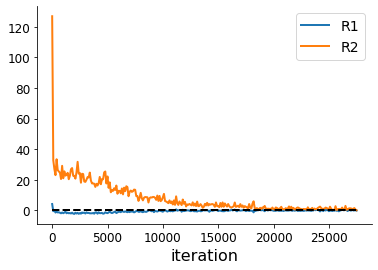

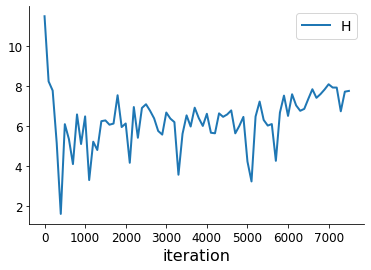

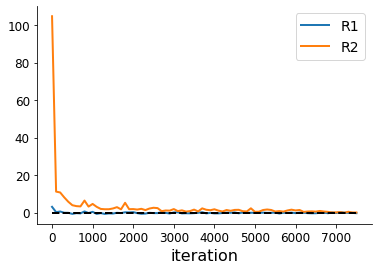

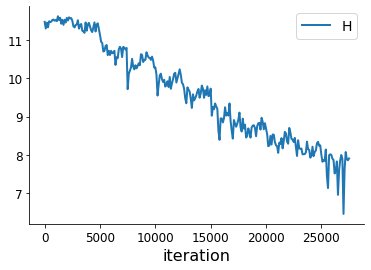

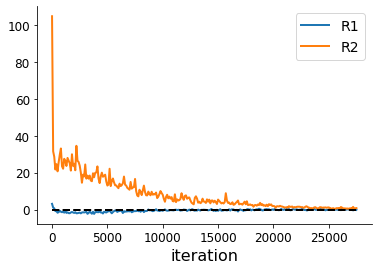

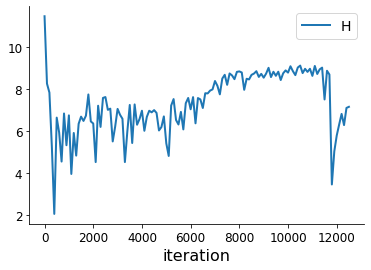

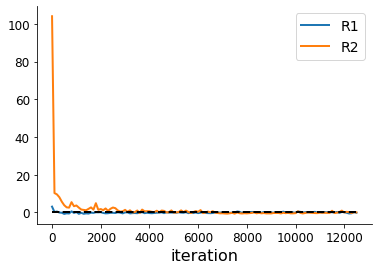

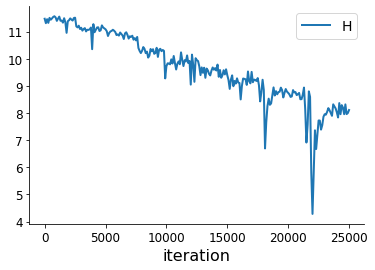

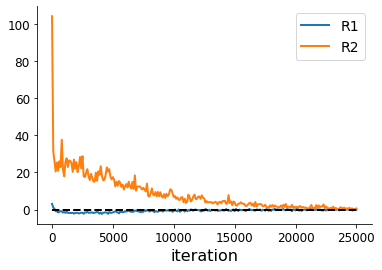

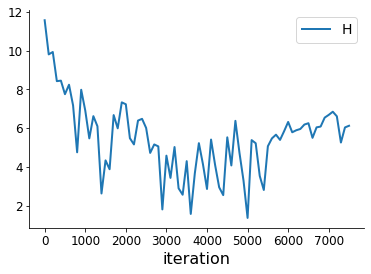

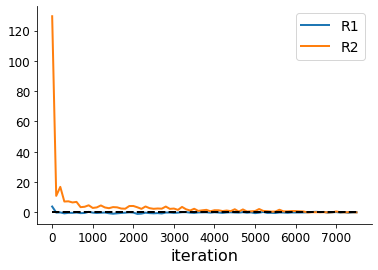

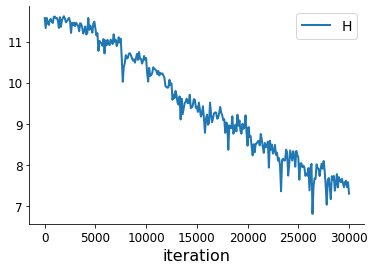

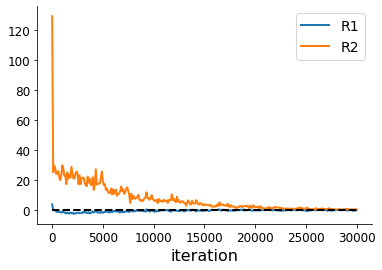

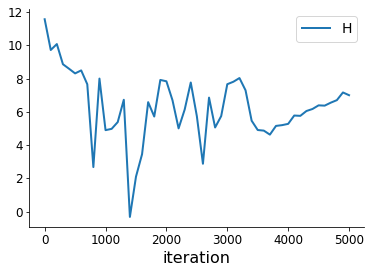

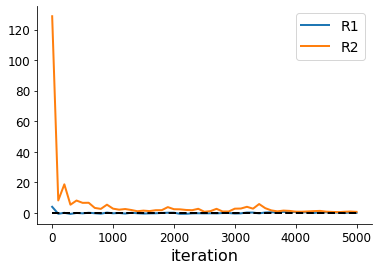

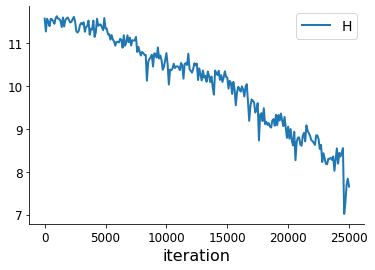

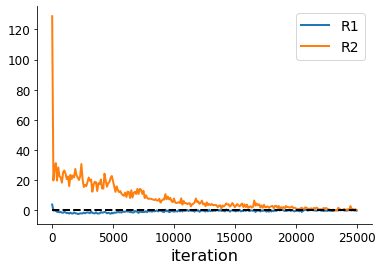

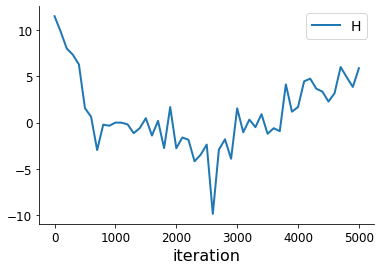

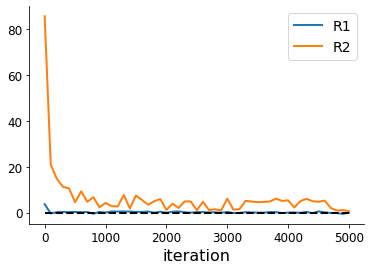

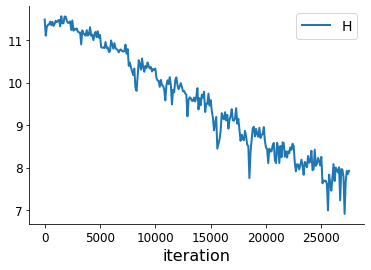

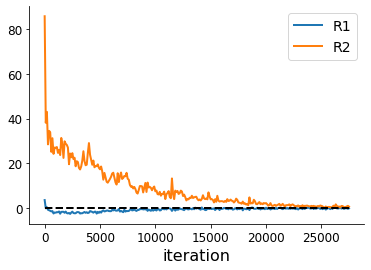

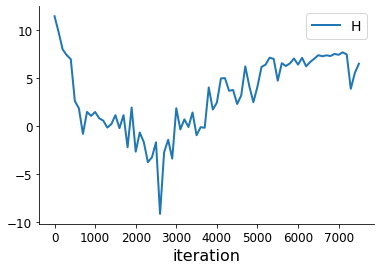

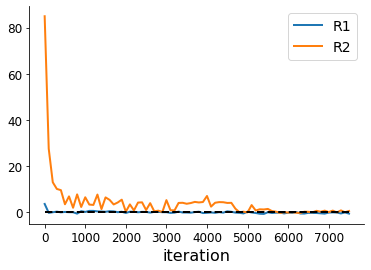

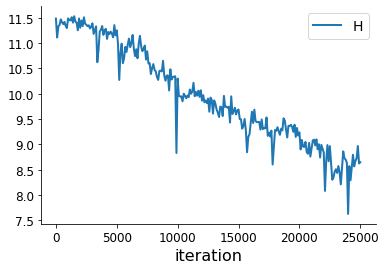

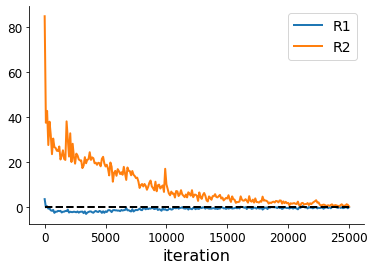

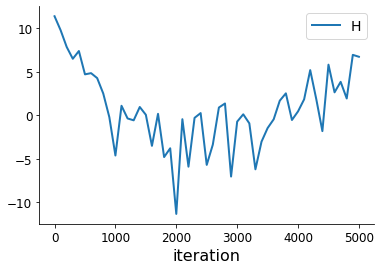

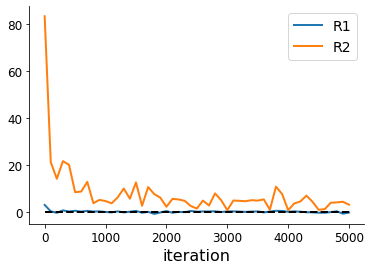

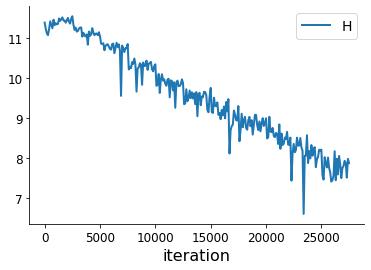

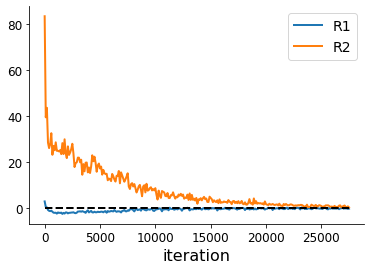

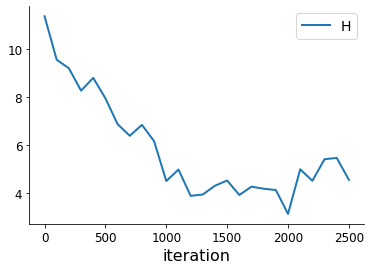

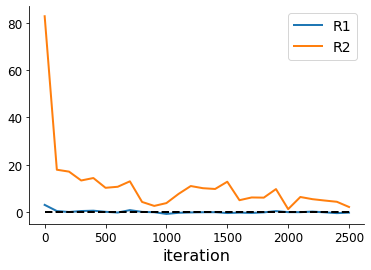

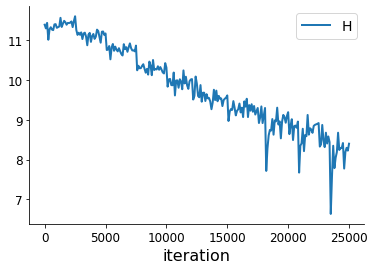

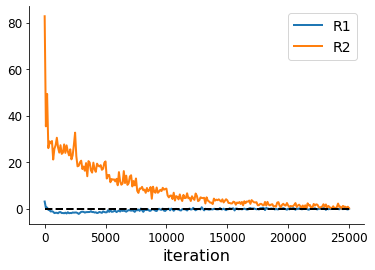

0.00_0.00
0.97_0.00
skipping
skipping
0.00_0.00


KeyboardInterrupt: 

In [9]:
M = 1000

# Define model
alphas = ['E', 'P', 'S', 'V']

npzfile = np.load('SV_mode.npz')
z_mode1 = npzfile['z_mode1'][0]
DH = z_mode1[4]
H = z_mode1[:4] + DH*np.array([1., 1., 0., 0.])

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"
mu = np.array([0., 0.5**2])

nus = {'E':0.5, 'P':0.5, 'S':0.5, 'V':0.5}

for alpha in alphas:
    neuron_ind = neuron_inds[alpha]
    nu = nus[alpha]
    name = "SSSN_drdh_%s" % alpha
    print(name)
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)
    # Define eps
    def dr(dh):
        h = tf.constant(H[None,:], dtype=tf.float32)

        x1 = f_r(SSSN_sim(h)[:,:,neuron_ind])
        x2 = f_r(SSSN_sim(h + dh)[:,:,neuron_ind])

        diff = tf.reduce_mean(x2 - x1, axis=1, keepdims=True)
        T_x = tf.concat((diff, diff ** 2), axis=1)

        return T_x
    model.set_eps(dr)

    epi_df = model.get_epi_df()
    epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
    epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
    paths = sorted(epi_df['path'].unique())
    
    if len(paths) == 0:
        continue
    
    best_Hs = []
    convergeds = []
    best_ks = []
    for i, path in enumerate(paths):
        #if (alpha == 'E'):
        #    if i in [0,3]:
        #        best_Hs.append(np.nan)
        #        convergeds.append(False)
        #        best_ks.append(0)
        #        continue
        epi_df2 = epi_df[epi_df['path'] == path]
        df_row = epi_df2.iloc[0]
        if not np.isclose(df_row['mu'], mu).all():
            print('skipping')
            continue
        init = df_row['init']
        init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
        nf = model._df_row_to_nf(df_row)
        aug_lag_hps = model._df_row_to_al_hps(df_row)
        best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                        alpha=0.05, nu=nu)
        best_Hs.append(best_H)
        convergeds.append(converged)
        best_ks.append(best_k)

    bestHs = np.array(best_Hs)
    best_ks = np.array(best_ks)

    best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
    ind = np.nanargmax(best_Hs)

    path = paths[ind]
    best_k = int(best_ks[ind])
    best_H = best_Hs[ind]

    print('ind', ind, path)
    print('best k', best_k)

    epi_df2 = epi_df[epi_df['path'] == path]
    df_row = epi_df2.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)

    dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

    z, log_q_z = dist.nf(M)
    T_x = model.eps(z).numpy()
    z = z.numpy()
    log_q_z = log_q_z.numpy()

    neurons = [alpha for alpha in neuron_inds.keys()]
    labels = [r'$dh_%s$' % alpha for alpha in neurons]
    fig, axs, = pairplot(z, range(4), labels, s=25, figsize=(6,6),
                         fontsize=18, lb=dist.nf.lb, ub=dist.nf.ub,
                         outlier_stds=3,
                         c=log_q_z, c_label='')
    
    plt.savefig(figdir + name + '_z.png')

    plot_T_x(None, T_x[:,0], xmin=-3., xmax=3., xlabel=r'$dx_%s$' % alpha, fontsize=20)
    plt.tight_layout()
    plt.savefig(figdir + name + '_Tx.png')




